This is to generate the relevant data from the exact diagonalziation that I myself coded

## DO ENTROPY WITH QUTIP FOR DEBUGGING

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import UnivariateSpline

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *

In [26]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/QPC_double_dot/"


In [27]:
data_route = "../../data/exact_diag_new/L=50/"

J=1


In [28]:
def get_time_at_bond(Times, N_bond):
    """ we estimate the time the qpc wavepacket spends at the bond with the qubit from the  FWHM of the
    occupations at the bond sites as a function of time """
    
    # estimate FWHF with an interpolation
    spline = UnivariateSpline(Times, N_bond - np.max(N_bond) / 2, s=0)
    bond_root = spline.roots()  # find the roots
    if (len(bond_root) < 2):
        print("not possible to estimate time at bond for ")
        
        tau_b = -Times[-1]
    else:
        # the first two roots yield the width at half maximum
        tau_b = bond_root[1] - bond_root[0]
    return tau_b


# Checking correct initial condition

Here we make sure that the occupation of the qubit 0 state is at roughly the same  for all different velocities. We achieve this by tweaking the initial conditions at at $\Omega=0$

In [29]:
# file_list = get_file_names_on(["om0.1","bw2.0","t0.1", "dd0fixed"], data_route)
file_list = get_file_names_on(["om0.0","Del2.0","t0.1"], data_route)

file_list

['exact_L50_J1.0_t0.1_om0.0_Del2.0_xo0_k1.5708_bindex7_maxtau60.000_tstep0.150_alpha0.000_beta1.000_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.1_om0.0_Del2.0_xo0_k0.7854_bindex7_maxtau60.000_tstep0.150_alpha0.021_beta0.979_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.1_om0.0_Del2.0_xo0_k1.2566_bindex7_maxtau60.000_tstep0.150_alpha0.000_beta1.000_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.1_om0.0_Del2.0_xo0_k1.4137_bindex7_maxtau60.000_tstep0.150_alpha0.000_beta1.000_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.1_om0.0_Del2.0_xo0_k1.4923_bindex7_maxtau60.000_tstep0.150_alpha0.000_beta1.000_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.1_om0.0_Del2.0_xo0_k0.9425_bindex7_maxtau60.000_tstep0.150_alpha0.007_beta0.993_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.1_om0.0_Del2.0_xo0_k0.6283_bindex7_maxtau60.000_tstep0.150_alpha0.059_beta0.941_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.1_om0.0_Del2.0_xo0_k1

Text(0.5, 0, 'Time')

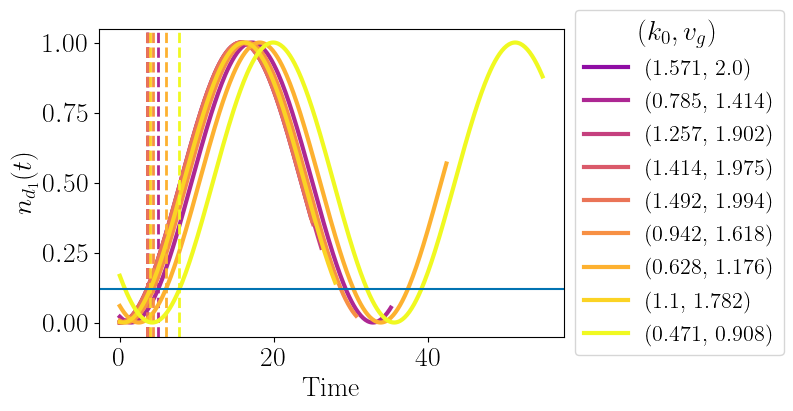

In [30]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name)  
  
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(param_dict["K0"])
    tau_to_bond = param_dict["bond_index"]/vg
    
    lab = "("+str(round(param_dict["K0"],3)) + ", " + str(round(vg,3))+")" 
    
    plt.plot(times, d0_density, linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)
    
plt.axhline(0.12)
plt.legend(title=r"$(k_0, v_g)$",loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")



# Generating Analysis dataframe

Here we put all the processed and raw data in a dataframe for convenient reading abd analysis

In [31]:
def rotate_rho(ρ, τ, T , ϕ0):
    # this rotates a qubits reduced density matrix around the x-axis up to angle tau*T
    # This is the free qubit rabi oscillations
    # Build the R matrix
    Rmatrix = np.zeros((2,2)) + 0j
    Rmatrix[0,0] = Rmatrix[1,1] = np.cos(τ*T)
    Rmatrix[1,0] = Rmatrix[0,1] =  -1j*np.exp(1j*ϕ0)*np.sin(τ*T)
    res_ = np.matmul(np.conj(Rmatrix.T), np.matmul(ρ, Rmatrix))
    # apply the rotation and return
    return res_

def get_bloch_angles(ρ):
    Cos_θ = 2*ρ[0,0] - 1
    θ_ = np.arccos(Cos_θ)
    Sin_ϕ = (ρ[1,0] - ρ[0,1])/(1j*np.sin(θ_))
    return Cos_θ,Sin_ϕ

def get_bloch_angles_time(ρ_list):
    # Calculate the Bloch angles for each time step

    costheta_list = []
    sinphi_list = []
    for i in range(0,len(ρ_list)):
        # mixed state bloch sphere representation. Check page 34 of my notes for this 
        r = ρ_list[i]
        Cos_theta_p, Sin_phi_p = get_bloch_angles(r)
        
        costheta_list.append(Cos_theta_p)
        sinphi_list.append(Sin_phi_p)
        
    return costheta_list, sinphi_list

In [32]:

file_list = get_file_names_on([], data_route)
file_list

['exact_L50_J1.0_t0.5_om0.0_Del6.0_xo8_k0.6283_bindex25_maxtau60.000_tstep0.150_alpha0.895_beta0.105_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.01_om0.0_Del6.0_xo8_k1.5708_bindex25_maxtau60.000_tstep0.150_alpha0.000_beta1.000_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.6_om0.3_Del2.0_xo0_k1.4923_bindex7_maxtau60.000_tstep0.150_alpha0.000_beta1.000_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.03_om0.1_Del2.0_xo0_k1.5708_bindex7_maxtau60.000_tstep0.150_alpha0.000_beta1.000_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t1.0_om0.3_Del2.0_xo0_k0.7854_bindex7_maxtau60.000_tstep0.150_alpha0.985_beta0.015_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.05_om0.1_Del6.0_xo8_k0.6283_bindex25_maxtau60.000_tstep0.150_alpha0.180_beta0.820_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t1.0_om0.1_Del2.0_xo0_k0.9425_bindex7_maxtau60.000_tstep0.150_alpha0.541_beta0.459_phi0.0_alpha_bond0.447_qinitold.h5',
 'exact_L50_J1.0_t0.001_om0.1_Del2.

In [33]:
# read the parameter dictionary to initialize 
param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_list[0])  

data_dict =  {key: [] for key in param_dict}
data_dict["times"] = []
data_dict["occupations"] = []
data_dict["d0_density"] = []
data_dict["qubit_rho"] = []
data_dict["entropy"] = []
data_dict["time_at_bond"] = []
data_dict["Max_entropy"] = []
data_dict["cos_theta"] = []
data_dict["sin_phi"] = []

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name) 
    # initialize the meta data
    for key in param_dict.keys():
        data_dict[key].append(param_dict[key])

    #  estimate the time that wavepacket spends at bondf
    bond_density = occupations[param_dict["bond_index"], :] + occupations[param_dict["bond_index"]+1, :]
    tau_bond = get_time_at_bond(times, bond_density)
    
    # get the bloch angles fo the qubit
    theta_list, phi_list = get_bloch_angles_time(qubit_rho)

    # save raw data 
    data_dict["times"].append(times.astype(np.float32))
    data_dict["occupations"].append(occupations.astype(np.float32))
    data_dict["d0_density"].append(d0_density.astype(np.float32)) 
    data_dict["qubit_rho"].append(qubit_rho.astype(np.complex64))
    # normalize entropy by maximally entangled singled 
    data_dict["entropy"].append((entropy/np.log(2)).astype(np.float32)) 
    # save processed data
    data_dict["time_at_bond"].append(tau_bond)
    data_dict["Max_entropy"].append(max(entropy/np.log(2)))
    data_dict["cos_theta"].append(theta_list)
    data_dict["sin_phi"].append(phi_list)

data_df = pd.DataFrame.from_dict(data_dict)

In [34]:
param_dict


{'L_qpc': 50,
 'Omega': 0.0,
 't': 0.6,
 'J': 1.0,
 'Jp': 1.0,
 'bond_index': 7,
 'K0': 1.0995574287564276,
 'X0': 0,
 'Spread': 2.0,
 'maxt_time': 60.0,
 'del_tau': 0.15037593984962405,
 'qubit_init': 'old',
 'Re_qubit_0': 0.0,
 'Im_qubit_0': -0.25406910050685516,
 'Re_qubit_1': 0.9671860690516781,
 'Im_qubit_1': 0.0,
 'phi': 0.0,
 'alfabond': 0.4472135954999579}

In [35]:
data_df["qubit_init"].unique()

array(['old'], dtype=object)

# Phase diagram

In [88]:
Om_ = 0.3

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["K0"]>0.1) & (data_df["t"]<3) & (data_df["qubit_init"]=="old") & (data_df["X0"]==0)

data_S = data_df[cond_].sort_values(by="K0")

S_df = data_S.pivot(index='K0', columns='t', values='Max_entropy')

S_df



t,0.001,0.010,0.030,0.050,0.070,0.100,0.200,0.300,0.400,0.500,0.600,0.800,1.000,2.000
K0,,,,,,,,,,,,,,
0.471239,0.001589,0.071569,0.127990,0.209481,0.167790,0.204192,0.193437,0.201264,0.163928,0.158940,0.143320,0.103163,0.121398,0.010046
0.628319,0.000457,0.025825,0.107154,0.147932,0.181508,0.204882,0.212100,0.219989,0.175805,0.159773,0.139696,0.108409,0.101020,0.010560
0.785398,0.000324,0.018959,0.087873,0.135958,0.177064,0.206452,0.238759,0.229717,0.175910,0.139924,0.137064,0.109008,0.095195,0.012587
0.942478,0.000220,0.013343,0.068759,0.118169,0.161594,0.197340,0.243736,0.211431,0.170776,0.131160,0.148951,0.096042,0.094472,0.012960
1.099557,0.000151,0.009424,0.053440,0.100698,0.142614,0.184728,0.235044,0.190863,0.165639,0.138316,0.158105,0.093201,0.096432,0.011847
1.256637,0.000113,0.007197,0.043395,0.087210,0.127050,0.172977,0.226311,0.174825,0.161570,0.149851,0.162268,0.096914,0.100426,0.011913
1.413717,0.000095,0.006136,0.037988,0.078864,0.117101,0.164866,0.223086,0.165178,0.158417,0.157320,0.165793,0.100012,0.103577,0.012033
1.492257,0.000091,0.005886,0.036740,0.076697,0.114508,0.162966,0.222294,0.163282,0.157534,0.159227,0.167004,0.100959,0.104719,0.012507
1.570796,0.000090,0.005796,0.036342,0.075968,0.113634,0.162377,0.222021,0.162644,0.157231,0.159860,0.167394,0.101307,0.105483,0.012596


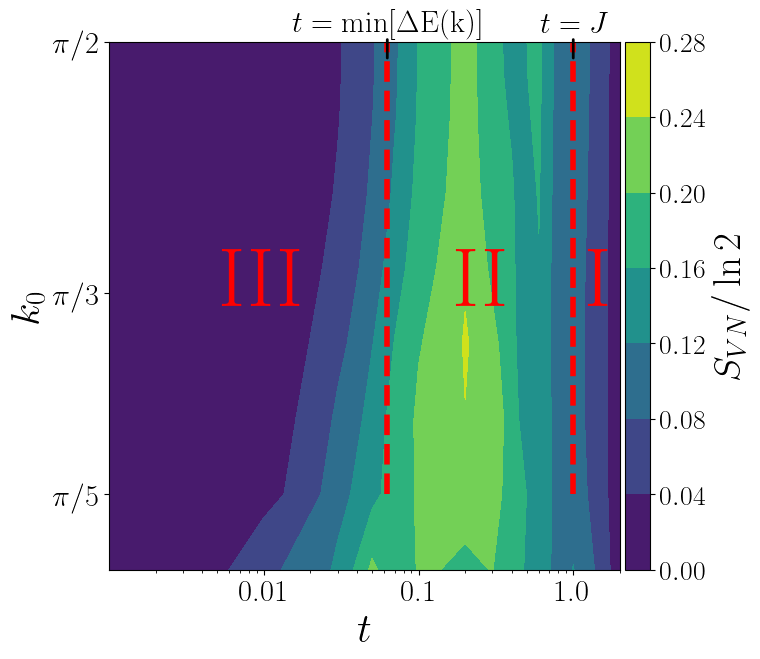

In [212]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(t_array, vg_array, S_df.values)
plt.xscale('log')

# Add a tick-like annotation
y_tick = np.pi/2 -0.04
ax.annotate(
    r'$t=\rm{min}[ \Delta E(k)]$', 
    xy=(np.pi/50, y_tick), 
    xytext=(x_tick, y_tick + 0.06), fontsize=22,ha='center')
ax.annotate(
    '', 
    xy=(np.pi/50, y_tick), 
    xytext=(x_tick, y_tick + 0.05),  # short vertical line
    arrowprops=dict(arrowstyle='-', color='black', lw=2))
ax.annotate(
    r'$t=J$', 
    xy=(1, y_tick), 
    xytext=(1, y_tick + 0.06), fontsize=22,ha='center')

ax.vlines(np.pi/50, ymin=0.4*np.pi/2, ymax=np.pi/2, color='red', lw=4, linestyle="dashed", clip_on=False)  # tick-like line

ax.annotate(
    '', 
    xy=(1, y_tick), 
    xytext=(1, y_tick + 0.05),  # short vertical line
    arrowprops=dict(arrowstyle='-', color='black', lw=2))

# Add the labels for each region
ax.annotate('II', xy=(0.2+np.pi/50, 0.65*np.pi/2), 
            xytext=(0.2+np.pi/50, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('III', xy=(0.01, 0.65*np.pi/2), 
            xytext=(0.01, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')

ax.annotate('I', xy=(1.5, 0.65*np.pi/2), 
            xytext=(1.5, 0.65*np.pi/2),ha='center', c="red", fontsize= 60,fontweight='bold')


ax.vlines(1, ymin=0.4*np.pi/2, ymax=np.pi/2, color='red', lw=4, linestyle="dashed", clip_on=False)  # tick-like line


ax.set_xticks( [0.01,0.1,1.0], [0.01,0.1,1.0] ,fontsize=22)
ax.set_yticks( [np.pi/5,np.pi/3,np.pi/2], labels=[r"$\pi/5$",r"$\pi/3$",r"$\pi/2$"],fontsize=22 )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{VN}/\ln{2}$', rotation=90, fontsize=28)

ax.set_ylabel(r"$k_0$",fontweight='bold',fontsize=30)
ax.set_xlabel(r"$t$",fontweight='bold',fontsize=30)

plt.tight_layout()

plt.savefig(fig_route+"entropy_phase_diagram_new.pdf",transparent=True)

# Entropy Production

In [154]:
t_ = 0.3

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_)  & (data_df["X0"]==8)

curr_df = data_df[cond_].sort_values(by="K0")


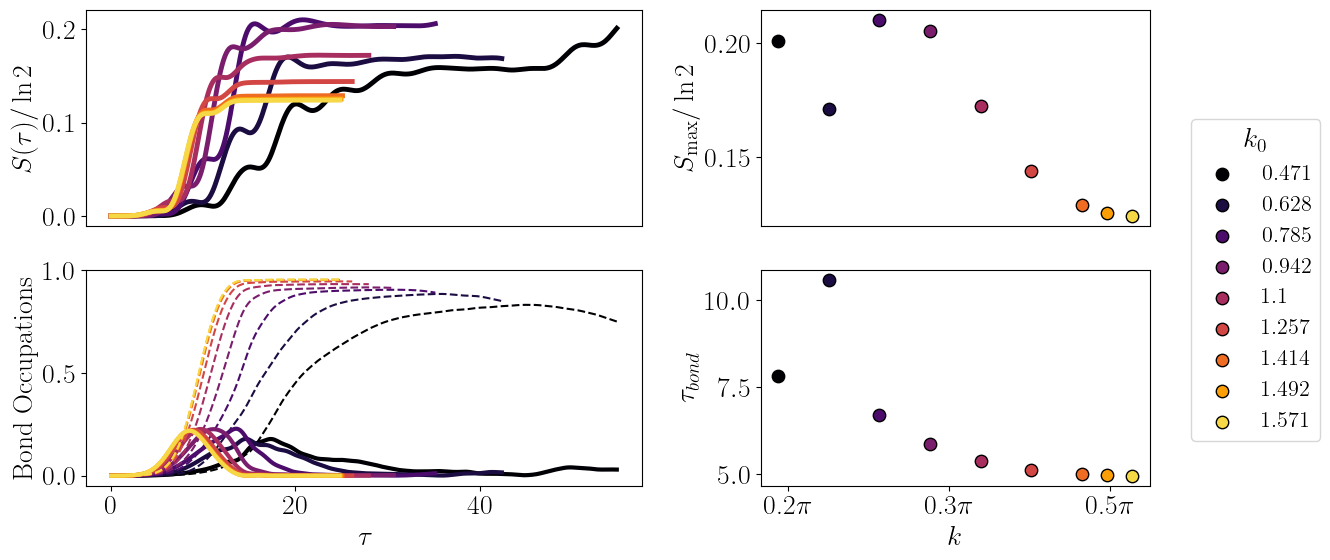

In [155]:
# Create 2x2 sub plots

fig = plt.figure(figsize=(12,6))

#plt.suptitle(om_s + ", " + bw_s + ", " + t_s )
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.7])
K0_unique = curr_df["K0"].unique()
colors = plt.cm.inferno(np.linspace(0.0,0.9,len(K0_unique)))

for i in range(0,len(K0_unique)):
    # generate the legend
    lab = str(round(K0_unique[i],3))
    # Entropy in time
    ax = plt.subplot(gs[0, 0]) # make it span both columns
    xvals = curr_df[curr_df["K0"]== K0_unique[i]]["times"].item()
    yvals = curr_df[curr_df["K0"]== K0_unique[i]]["entropy"].item()
    ax.plot(xvals,yvals, linewidth=3.5, c=colors[i])
    
    # max entropy
    ax = plt.subplot(gs[0, 1])
    ax.scatter(K0_unique[i], max(yvals), c=[colors[i]], s=80, edgecolor='black', zorder=7,label=lab)
    
    # plot density at the bond in time and transmission
    bindex = curr_df[curr_df["K0"]== K0_unique[i]]["bond_index"].item()
    occ_matrix = curr_df[curr_df["K0"]== K0_unique[i]]["occupations"].item()
    bond_density = occ_matrix[bindex, :] + occ_matrix[bindex+1, :] 
    transmission = np.sum(occ_matrix[bindex+2:,:], axis=0)
    
    ax = plt.subplot(gs[1, 0]) # row 1, col 0
    ax.plot(xvals,bond_density, linewidth=3, c=colors[i])    
    ax.plot(xvals, transmission, linestyle="dashed", linewidth=1.5, c=colors[i])
    # plot time spent at bond
    ax = plt.subplot(gs[1, 1]) # row 1, col 1
    ax.scatter(K0_unique[i], curr_df[curr_df["K0"]== K0_unique[i]]["time_at_bond"], c=[colors[i]], s=80, edgecolor='black', zorder=7)



# Set up labels and legends

plt.subplot(gs[0, 0]).set_ylabel(r"$S(\tau)/\ln{2}$")
plt.subplot(gs[0, 0]).set_xticks([])

plt.subplot(gs[0, 1]).set_xticks([])
plt.subplot(gs[0, 1]).set_ylabel(r"$S_{\rm{max}}/\ln{2}$")
# plt.subplot(gs[0, 1]).legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(gs[1, 0]).set_ylabel(r"Bond Occupations")
plt.subplot(gs[1, 0]).set_xlabel(r"$\tau$")

plt.subplot(gs[1, 1]).set_ylabel(r"$\tau_{bond}$")
plt.subplot(gs[1, 1]).set_xlabel(r"$k$")
# write x axis in units of pi
plt.subplot(gs[1, 1]).xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.subplots_adjust(wspace=0.16, hspace=0.09)

plt.tight_layout()

### Comparing with Qutip

In [156]:
print(K0_unique)


[0.4712389  0.62831853 0.78539816 0.9424778  1.09955743 1.25663706
 1.41371669 1.49225651 1.57079633]


In [93]:
curr_df[curr_df["K0"]== K0_unique[-1]]

,L_qpc,Omega,t,J,Jp,bond_index,K0,X0,Spread,maxt_time,...,alfabond,times,occupations,d0_density,qubit_rho,entropy,time_at_bond,Max_entropy,cos_theta,sin_phi
447,50,0.3,0.3,1.0,1.0,25,1.570796,8,6.0,60.0,...,0.447214,"[0.0, 0.15037593, 0.30075186, 0.45112783, 0.60...","[[0.016255334, 0.010945518, 0.006958369, 0.004...","[1.3852583e-28, 0.002033783, 0.008118586, 0.01...","[[[(1.3852583e-28+0j), (-4.973858e-16+2.160404...","[2.4109912e-14, 1.9318047e-09, 3.277444e-08, 1...",4.962946,0.124267,"[(-1+0j), (-0.9959324343532008-1.4050969239388...","[(-35.28208350160896-0j), (-0.9999999866102777..."


In [94]:
drold = '../../data/sims/L=21/'
file_listold = get_file_names_on(["om{}_".format(Om_), "k1.5708","t{}".format(t_),"bw2.0"], drold)
file_name = file_listold[0]
param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(drold,file_name)
τb  = param_dict["bond_index"]/(2 * J * np.sin(param_dict["k0"]))

file_listold

['res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.3_om0.3_dd0fixed.hdf5']

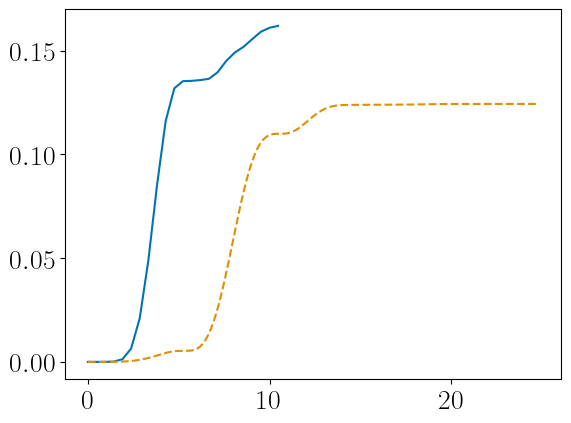

In [95]:
xvals = curr_df[curr_df["K0"]== K0_unique[-1]]["times"].item()
yvals = curr_df[curr_df["K0"]== K0_unique[-1]]["entropy"].item()

times_coarse = np.linspace(times[0], times[-1], len(VN_entropy))

plt.plot(times_coarse, VN_entropy/np.log(2))
plt.plot(xvals, curr_df[curr_df["K0"]==K0_unique[-1]]["entropy"].item() , linestyle="dashed")

In [96]:
data_full_df = pd.read_csv('../../data/exp_pro/exploration_data_L=21.csv')
data_full_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_full_df = data_full_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()
data_full_df["Max_entropy_norm"] = data_full_df["max_VN_entropy"]/np.log(2)

In [97]:
hop_list = [0.01, 0.1, 0.3, 0.4,0.5,1.0]

In [98]:
cond_old =  (data_full_df["x_spread"] == 2.0) & (data_full_df["Omega"] == Om_) & (data_full_df["t"].isin(hop_list))
cond_ = (data_df["Omega"]==Om_) & (data_df["K0"]>0.1)  & (data_df["qubit_init"]=="fixed") & (data_df["t"].isin(hop_list))
print(data_full_df[cond_old]["t"].unique())
print(data_df[cond_]["t"].unique())

[0.01 0.3  0.1  0.4  0.5  1.  ]
[]


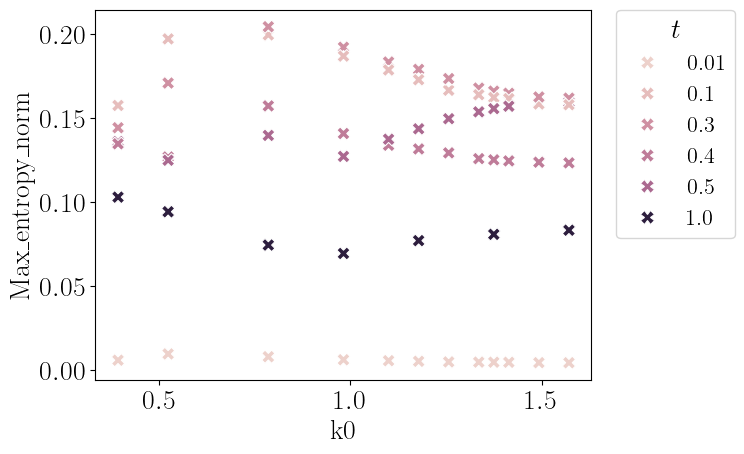

In [99]:
# odl data
sns.scatterplot(data= data_full_df[cond_old], x = "k0", y="Max_entropy_norm", s = 90, marker="X", hue="t")
sns.scatterplot(data= data_df[cond_], x = "K0", y="Max_entropy", s = 70, marker="o",hue="t")

plt.legend(
    title=r"$t$",
    bbox_to_anchor=(1.05, 1),  # position legend outside to the right
    loc='upper left',
    borderaxespad=0
)

# Single cases

In [107]:
k0_list = np.sort(data_df["K0"].unique())
print(k0_list)
k0_ = k0_list[0]

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_) & (data_df["K0"]==k0_)  & (data_df["X0"]==8)
curr_df = data_df[cond_]


[0.4712389  0.62831853 0.78539816 0.9424778  1.09955743 1.25663706
 1.41371669 1.49225651 1.57079633]


## Wavefunction

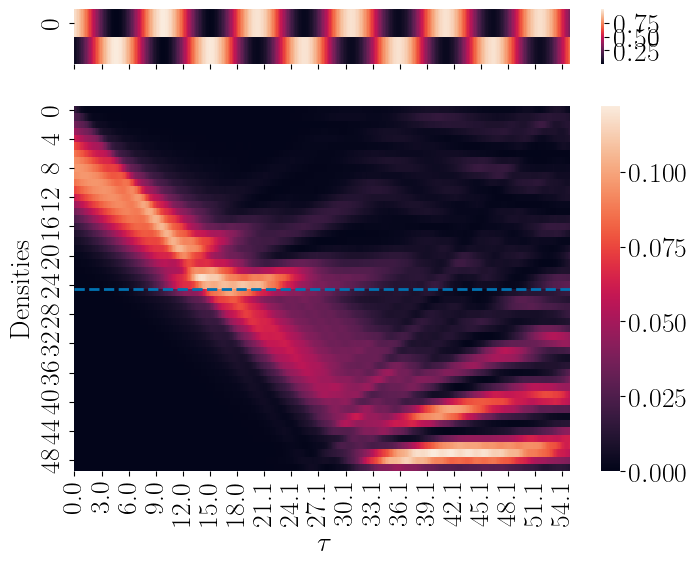

In [108]:
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

# n_d1
n_d1 = curr_df["d0_density"].item()
sns.heatmap([n_d1,1-n_d1],ax=ax[0])
traj_matrix = curr_df["occupations"].item()
time_range = curr_df["times"].item()
sns.heatmap(traj_matrix,ax=ax[1])

ax[1].set_xlabel(r"$\tau$")

ax[1].set_ylabel("Densities")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)

ax[1].axhline(curr_df["bond_index"].item(), linewidth=2, linestyle="dashed")
ax[1].set_xticks(tick_posx,xtick_label);


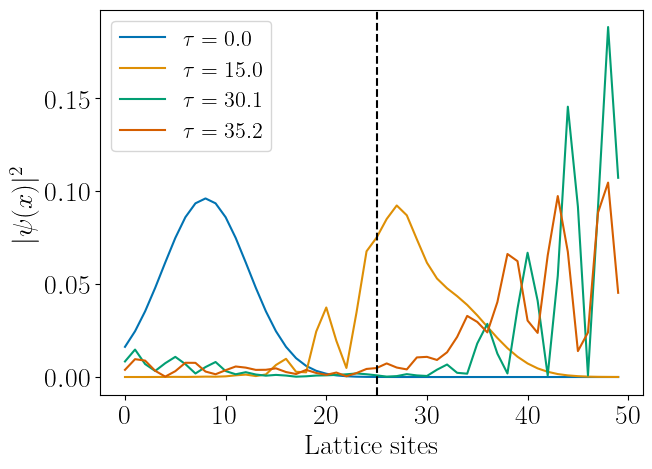

In [102]:
fig, ax = plt.subplots(1,1,figsize=(bwidth,bheight))

plt.plot(traj_matrix[:,0], label=r"$\tau={:.3}$".format(time_range[0]))
plt.plot(traj_matrix[:,100], label=r"$\tau={:.3}$".format(time_range[100]))
plt.plot(traj_matrix[:,200], label=r"$\tau={:.3}$".format(time_range[200]))
plt.plot(traj_matrix[:,-1], label=r"$\tau={:.3}$".format(time_range[-1]))
plt.axvline(25, c="black", linestyle="dashed")
plt.xlabel("Lattice sites")
plt.ylabel(r"$|\psi (x)|^2$")
plt.legend()

## Bloch Sphere

In [79]:
costheta = curr_df["cos_theta"].item()
sinphi = curr_df["sin_phi"].item()
time_range = curr_df["times"].item()
bindex = curr_df["bond_index"].item()
ϕ0 = curr_df["phi"].item()
rhot = curr_df["qubit_rho"].item()

τbond = bindex/(2*J*np.sin(k0_))
cosθ0 = costheta[0]

data_df.columns


Index(['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread',
       'maxt_time', 'del_tau', 'qubit_init', 'Re_qubit_0', 'Im_qubit_0',
       'Re_qubit_1', 'Im_qubit_1', 'phi', 'alfabond', 'times', 'occupations',
       'd0_density', 'qubit_rho', 'entropy', 'time_at_bond', 'Max_entropy',
       'cos_theta', 'sin_phi'],
      dtype='object')

In [80]:
rho_free_list = [rhot[0]]
theta_free_list = [np.arccos(np.real(cosθ0))]
phi_free_list = [ϕ0]

# calculate the free qubit bloch angles as a funciton of time
# by using the rotaiton matrix of the free dynamics

for i in range(1,len(time_range)):
    # rotate up to time tau
    τ = time_range[i] 
    rho_tau = rotate_rho(rho_free_list[0], τ, t_ , ϕ0)
    # get the angles at that tau
    Cos_theta_p, Sin_phi_p = get_bloch_angles(rho_tau)
    
    rho_free_list.append(rho_tau)
    theta_free_list.append(np.arccos(Cos_theta_p))
    phi_free_list.append(np.arcsin(Sin_phi_p))


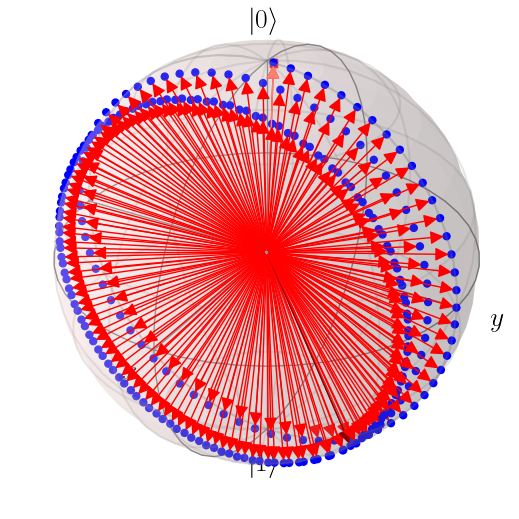

In [81]:
# Now plot the numerical coupled case
dd_theta = np.arccos(costheta)
dd_phi = np.arcsin(sinphi)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*np.sin(dd_phi)
z_ = np.asarray(costheta)

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

# writting out free case solution in spherical coordinates
x_free = np.sin(theta_free_list)*np.cos(phi_free_list)
y_free = np.sin(theta_free_list)*np.sin(phi_free_list)
z_free = np.cos(theta_free_list)

free_points = [x_, y_, z_]
free_first= [x_[0], y_[0], z_[0]] # first point for different color

bs = Bloch()

bs.add_vectors(coupled_vectors)
# now plot the first and last vectors and points in a different color
bs.add_vectors(coupled_vectors[0])
bs.add_vectors(coupled_vectors[-1])
bs.vector_color = ["red"]*len(coupled_vectors) + ["salmon", "darkred"]
bs.vector_width = 1.0

# now add the free vectors
bs.add_points(free_points)
bs.add_points(free_first)

#bs.view = [-20, 30]  

bs.show()

Text(0.5, 0, '$\\tau$')

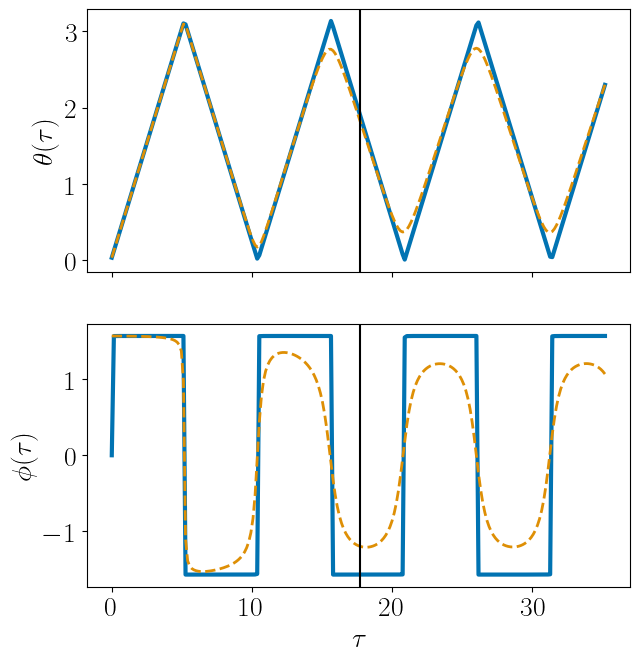

In [82]:

fig, ax = plt.subplots(2,1,figsize=(bwidth,1.5*bheight), sharex = True)

ax[0].plot(time_range, np.real(theta_free_list), linewidth=3)
ax[0].plot(time_range, np.real(dd_theta), linewidth=2.0, linestyle="dashed")
ax[0].axvline(τbond, c="black")

ax[1].plot(time_range, np.real(phi_free_list), linewidth=3 )
ax[1].plot(time_range, np.real(dd_phi),linewidth=2.0, linestyle="dashed")
ax[1].axvline(τbond,c="black")

ax[0].set_ylabel(r"$\theta (\tau)$")
ax[1].set_ylabel(r"$\phi (\tau)$")
ax[1].set_xlabel(r"$\tau$")